# Implements encoder/decoder for weak lensing outputs

The major idea is to see if I can compress the data in the snapshot files.
The result is that the compression of many different algorithms based on CNNs (of different depths) is not so much different than averaging neighboring cells (as shown at the end).  This in retrospect is not so surprising as there are differences on the cell scale in the maps that make compression challenging.

Set configurations for google COLAB if running there

In [7]:
import os


use_COLAB = 0 #1 is for on colab, and 2 is for on local machine but using colab

if use_COLAB >= 1:
  if use_COLAB == 2: # for running in VS CODE
      from colabcode import ColabCode
      ColabCode(port=10000)
  #mount drive
  from google.colab import drive
  drive.mount('/content/gdrive')

  WORK_AREA = '/content/gdrive/My Drive/weaklensing_ML/' #columbialensing/
  os.chdir(WORK_AREA)


## extract tarfiles if necessary and set specs for run



In [15]:

import tarfile
import os
import shutil
from astropy.io import fits
import numpy as np
from scipy.ndimage import zoom
import re
import tensorflow as tf
import random

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

#whether we are training or loading saved
train = True
load_saved = 1

# Specify the directory containing the .tar files
if use_COLAB >= 1:
    directory_path = './columbialensing/'
else:
        directory_path = '../weaklensing_ML/columbialensing/'
number_batches = 10
#normalize_by_RMS = True #set to one if you want to renormalize by RMS

# image_size
image_size = 1024
sub_image_size = 32 #needs to divide image into these units; must divide evenly image_size
                    #division is using that it is unlikely there are learnable correlations
                    #that allow one to compress the data on large scales in the images
                    #dividing images gives more samples to learn correlations
number_fits_files = 16 # just sto start


number_subimages_across =image_size//sub_image_size




#extracts only if indicated (could make this more elegant by checking to see if they exist)
extract_tarfiles = False  #if I need to extract tarfiles
suffix = f"_{image_size}"
run_suffix = rf"im{image_size}"
if extract_tarfiles:
    # Use a regular expression to match .tar files with the desired suffix
    pattern = re.compile(rf"{suffix}.tar$")

    # List all matching .tar files in the directory
    all_tar_files = [f for f in os.listdir(directory_path) if pattern.search(f)]

    # Extract the tar archive
    for tar_file in all_tar_files:
        #print(tar_file)
        tar_file_path = os.path.join(directory_path, tar_file)
        with tarfile.open(tar_file_path, 'r') as archive:
            archive.extractall(path=directory_path)




Num GPUs Available:  1


# Read into memory the data

In [20]:
#parameters we need
normalize_by_RMS = True #first time set to zero
LOGFIELD = False

def get_labels_for_file(dir_name):
    """
    Extracts labels from the tar file name.
    For the file "Om0.183_si0.958_256.tar", the labels will be [0.183, 0.958].

    Args:
    - tar_file_name (str): Name of the tar file.

    Returns:
    - list: List containing the two labels extracted from the filename.
    """
    # Split the filename on underscores
    parts = dir_name.split('_')

    # Extract the numeric values for 'Om' and 'si'
    om_label = float(parts[0][2:])
    si_label = float(parts[1][2:])

    return [om_label, si_label]

#now loop through all files in the
pattern = re.compile(rf"{suffix}$")
#all_directories = [f for f in os.listdir(directory_path) if pattern.search(f)]
all_directories = ["Om0.268_si0.801"] # "Om0.283_si0.805_256"
num_cosmologies = len(all_directories)

random.shuffle(all_directories) #this makes it so that there is no particular order for the directories
#print(all_directories)

#tensor of labels; there are two labels for each
numsubimages = number_subimages_across**2
number_images = number_fits_files*numsubimages
#cosmology_labels = np.empty((len(all_directories), number_images, 2), dtype=np.float16)

RMS =0 #first time set to zero
data_array = np.empty((num_cosmologies, number_images, sub_image_size, sub_image_size), dtype=np.float16)

number_subimages_total = 0
for idy, dir_name in enumerate(all_directories):


    #if idy%10 ==0:
    print("reading in", dir_name)
    dir_path = os.path.join(directory_path, dir_name)

    all_files = os.listdir(dir_path)
    fits_files = [f for f in all_files if f.endswith('.fits')]



    for idx, file in enumerate(fits_files):
        if idx >= number_fits_files:
            break

        with fits.open(os.path.join(dir_path, file)) as hdul:

            original_data = hdul[0].data

            #if RMS == 0: #get RMS to divide by for first file to normalize everything
            #    RMS = np.sqrt(np.var(hdul[0].data))
            #    print(f"RMS={RMS}")

            ##get rid of NANs, which affects a few files
            #if np.isnan(original_data).any():
            #    continue
            #I've cleaned this out already
            for i in range(number_subimages_across):
                for j in range(number_subimages_across):
                    data_array[idy][numsubimages*idx+ number_subimages_across*i+j] = original_data[sub_image_size*i:sub_image_size*(i+1),\
                                                                  sub_image_size*j:sub_image_size*(j+1)]
                number_subimages_total +=1



    #since all fits files in one directory have the same label
    cosmology = get_labels_for_file(dir_name)
    #cosmology_labels[idy] = np.array([cosmology for i in range(number_fits_files)])


    #flatten data_array[idy][numsubimages*idx+ number_subimages_across*i+j]

if LOGFIELD:
    meanf = np.mean(data_array)
    stdf = np.std(data_array)
    minf = np.min(data_array)
    data_array = np.log((data_array-minf)/stdf + 1e-3)  #this was 1e-30 before 10/29/24, but 1e-3 makes sense to me
    print("LOGFIELD = True :  mean, std, min", meanf, stdf, minf)
elif normalize_by_RMS:
    stdf = np.std(data_array)
    data_array = data_array/stdf
    print(stdf)
    print("normalize_by_RMS = True : std", stdf)

WL_tensor = tf.convert_to_tensor(data_array)

WL_tensor = tf.reshape(WL_tensor, (-1, WL_tensor.shape[2], WL_tensor.shape[3]));

WL_tensor = WL_tensor[..., np.newaxis]  # Add channel dimension



reading in Om0.268_si0.801
0.01843
RMS = True : std 0.01843


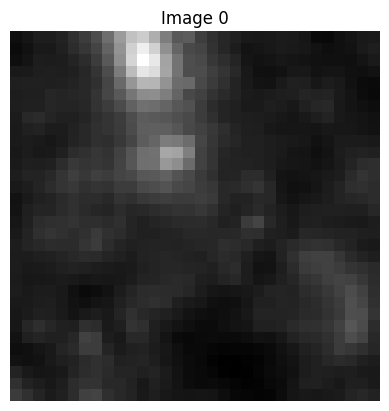

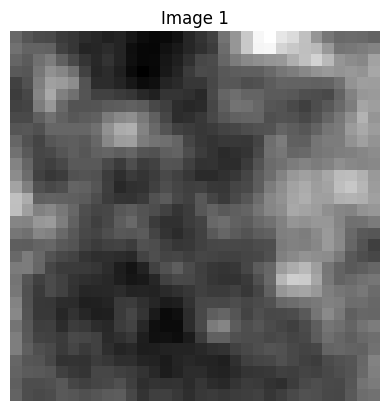

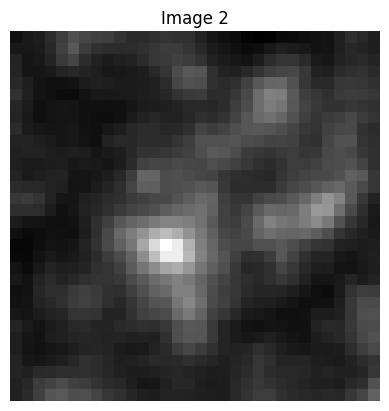

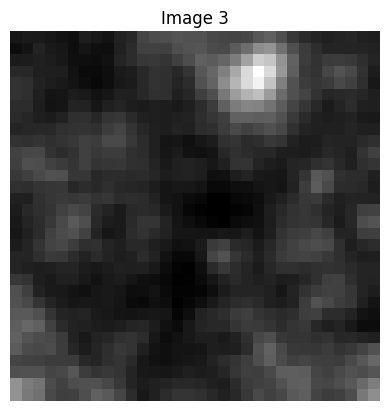

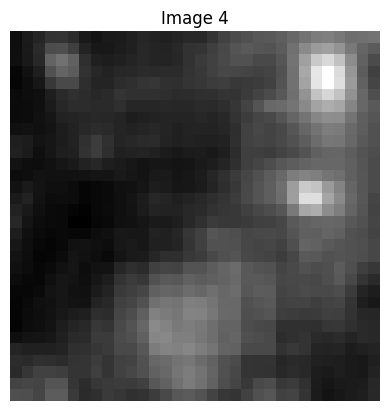

In [21]:
import matplotlib.pyplot as plt

%matplotlib inline

# Number of images you want to display
num_images_to_display = 5

for i in range(num_images_to_display):
    # Extract the i-th image tensor
    image_tensor = WL_tensor[i, :, :, 0]
    # Use TensorFlow operations if needed (optional)
    # Display the image
    plt.imshow(image_tensor, cmap='gray')
    plt.title(f"Image {i}")
    plt.axis('off')
    plt.show()


In [22]:
print("number_subimages_across =", number_subimages_across )
print("total number of images =", number_subimages_across*number_subimages_across*number_fits_files *len(all_directories), number_subimages_total)
np.shape(WL_tensor)

number_subimages_across = 32
total number of images = 16384 512


TensorShape([16384, 32, 32, 1])

# Renormalize the image data

Number of NaNs: 0
Number of Infinities: 0
Min value: -1.548828125
Max value: 9.53125
Tensor shape: (17, 32, 32, 1)
Mean value: -0.07708740234375
Variance value: 0.6669921875
Mean value: -0.07707119115409092
Variance value: 0.6670937639813692
Standard Deviation: 0.81689453125


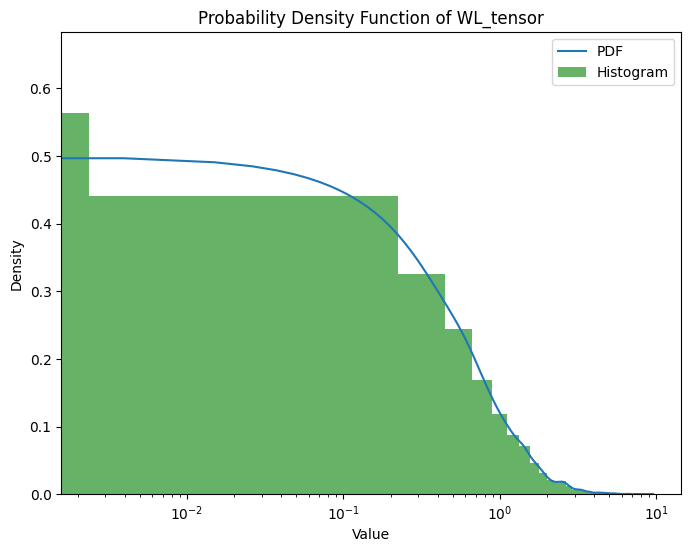

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import tensorflow as tf


# Implement Welford's algorithm for numerically stable mean and variance calculation
def welford_algorithm(data):
    n = 0
    mean = 0.0
    M2 = 0.0

    for x in data:
        n += 1
        delta = x - mean
        mean += delta / n
        delta2 = x - mean
        M2 += delta * delta2

    variance = M2 / (n - 1) if n > 1 else float('nan')
    return mean, variance

calculate_statistics = True

if calculate_statistics:
    # Assuming WL_tensor is a TensorFlow tensor of floating-point numbers

    # Convert the TensorFlow tensor to a NumPy array
    WL_tensor_np = WL_tensor.numpy()
    WL_tensor_np = WL_tensor_np[::1000, :, :, :]  # Downsample the tensor for faster computation

    # Check for NaNs and Infinities
    num_nans = np.isnan(WL_tensor_np).sum()
    num_infs = np.isinf(WL_tensor_np).sum()
    print(f"Number of NaNs: {num_nans}")
    print(f"Number of Infinities: {num_infs}")


    # Inspect the range of values
    min_value = WL_tensor_np.min()
    max_value = WL_tensor_np.max()
    print(f"Min value: {min_value}")
    print(f"Max value: {max_value}")

    # Check the shape of the tensor
    tensor_shape = WL_tensor_np.shape
    print(f"Tensor shape: {tensor_shape}")

    # Manually calculate the mean and variance
    mean_value = np.mean(WL_tensor_np)
    variance_value = np.var(WL_tensor_np)
    print(f"Mean value: {mean_value}")
    print(f"Variance value: {variance_value}")


    # Flatten the tensor to 1D for easier processing
    WL_tensor_flat = WL_tensor_np.flatten()




    # Calculate mean and variance using Welford's algorithm
    mean_value, variance_value = welford_algorithm(WL_tensor_flat)
    print(f"Mean value: {mean_value}")
    print(f"Variance value: {variance_value}")


    # Calculate the standard deviation
    std_dev = np.std(WL_tensor_np)
    print(f"Standard Deviation: {std_dev}")

    DO_KDE= True
    if DO_KDE:
        # Flatten the tensor to 1D for PDF calculation
        WL_tensor_flat = WL_tensor_np.flatten()

        # Calculate the PDF using Gaussian Kernel Density Estimation
        kde = gaussian_kde(WL_tensor_flat)
        x_values = np.linspace(WL_tensor_flat.min(), WL_tensor_flat.max(), 1000)
        pdf_values = kde(x_values)

        # Plot the PDF
        plt.figure(figsize=(8, 6))
        plt.semilogx(x_values, pdf_values, label='PDF')
        plt.hist(WL_tensor_flat, bins=50, density=True, alpha=0.6, color='g', label='Histogram')
        plt.title('Probability Density Function of WL_tensor')
        plt.xlabel('Value')
        plt.ylabel('Density')
        plt.legend()
        plt.show()

# Motivated binning method that partitions so that variance in each bin should be the same

In [24]:
import numpy as np
import tensorflow as tf

# Flatten the tensor to 1D for easier processing
WL_tensor_flat =  tf.reshape(WL_tensor, [-1]) # WL_tensor_np.flatten()

# Ensure WL_tensor_flat is a NumPy array
if isinstance(WL_tensor_flat, tf.Tensor):
    WL_tensor_flat_np = WL_tensor_flat.numpy()
else:
    WL_tensor_flat_np = WL_tensor_flat

# Step 1: Sample a Subset of the Data
sample_size = 1000000  # Adjust based on available memory and desired accuracy
indices = np.random.choice(len(WL_tensor_flat_np), size=sample_size, replace=False)
sampled_data = WL_tensor_flat_np[indices]


# Step 2: Sort the Sampled Data
sorted_data = np.sort(sampled_data)
n = len(sorted_data)


#print("num zeros = ", np.sum(sampled_data == 0), np.sum(WL_tensor_flat_np == 0), np.sum(sorted_data ==0))

#print("sorted_data =", sorted_data)

# Step 3: Compute Cumulative Sums and Cumulative Sum of Squares
cum_sum = np.cumsum(sorted_data, dtype=float)
cum_sum_sq = np.cumsum(sorted_data**2, dtype=float)

# Step 4: Compute Total Variance and Target Variance per Bin
target_std = .01
target_variance = target_std**2
num_bins= 50 # just a guess to start

for iiter in range(3): # iterate five times to reach target std

    target_variance_per_bin = target_variance/ num_bins

    print(f"Target Variance: {target_variance}")
    print(f"Target Variance per Bin: {target_variance_per_bin}")


    # Step 5: Find Bin Edges
    bin_edges = []
    num_points_arr = []
    total_variance_bin_arr = []
    mean_bin_arr = []

    start_index = 0
    while start_index < n:
        found = False
        for end_index in range(start_index + 10, n):
            num_points = end_index - start_index + 1
            #if num_points <= 3:
            #    continue
            # Sum and sum of squares in the bin
            sum_bin = cum_sum[end_index] - (cum_sum[start_index - 1] if start_index > 0 else 0)
            sum_sq_bin = cum_sum_sq[end_index] - (cum_sum_sq[start_index - 1] if start_index > 0 else 0)
            # Mean and variance in the bin
            mean_bin = sum_bin / num_points
            total_variance_bin = (sum_sq_bin - num_points*mean_bin**2)/(num_points-1)*num_points/n  #total contribute to variance
            if total_variance_bin >= target_variance_per_bin:
                bin_edges.append(sorted_data[end_index])
                num_points_arr.append(num_points)
                total_variance_bin_arr.append(total_variance_bin)
                mean_bin_arr.append(mean_bin)
                #print("sums = ",  sum_bin , sum_sq_bin, mean_bin, sum_sq_bin / num_points, num_points, "total_variance_bin = ", total_variance_bin, target_variance_per_bin, num_points/n, ((sum_sq_bin / num_points) - mean_bin**2) )
                #print("indexes =", start_index, end_index, cum_sum[end_index], cum_sum_sq[start_index - 1]) 
                start_index = end_index + 1
                found = True
                break
        if not found:
            # Include all remaining data in the last bin
            bin_edges.append(tf.reduce_max(WL_tensor)) #       sorted_data[-1])
            break

    num_bins = len(bin_edges)
    print("num bins=", num_bins)



# Step 6: Digitize the Original Data Using Bin Edges
# Convert bin_edges to numpy array for consistency
bin_edges = np.array(bin_edges)

# Use np.digitize to find bin indices for the entire dataset
bin_indices = np.digitize(WL_tensor_flat_np, bin_edges, right=True)-1

# Adjust bin_indices to ensure they are within the valid range
# Since mean_values has length len(bin_edges) + 1, bin_indices should be in [0, len(bin_edges)]
#may be necessary since our bins are not based on everything
bin_indices = np.clip(bin_indices, 0, len(bin_edges))


# Digitize the tensor values according to the binning scheme
#bin_indices = tf.searchsorted(bin_edges, WL_tensor_flat, side='right') - 1


#let's calculate the mean we expect in each bin
#MIGHT NEED TO GAURD AGAINST ZEROS
mean_values = [np.mean(WL_tensor_flat[bin_indices == index]) for index in range(len(bin_edges)-1)]




print("mean values = ", mean_values)
print("bin_edges = ", bin_edges)
print("num_points = ", num_points_arr)
print("total_variance_bin =", total_variance_bin_arr)

encoded_tensor = tf.gather(mean_values, bin_indices) #realization of quantized tensor


#reshape
bin_indices = tf.reshape(bin_indices, [number_images,  sub_image_size*sub_image_size])


# Compute mean values
# mean_values = np.zeros(len(bin_edges) + 1)
# for i in range(len(mean_values)):
#     indices_in_bin = bin_indices == i
#     if np.any(indices_in_bin):
#         mean_values[i] = np.mean(WL_tensor_flat_np[indices_in_bin])
#     else:
#         # Handle empty bins if necessary
#         mean_values[i] = 0

# # Map bin indices to mean values
# encoded_tensor_np = mean_values[bin_indices]

# # If you need to convert back to a TensorFlow tensor
# encoded_tensor = tf.convert_to_tensor(encoded_tensor_np, dtype=WL_tensor_flat.dtype)

# # Compute Quantization Error
# 
# 
diff_tensor = encoded_tensor - WL_tensor_flat

# Compute the standard deviation of the quantization error
std_quantized = tf.math.reduce_std(diff_tensor).numpy()

# Convert indices to a TensorFlow tensor
indices_tf = tf.constant(indices, dtype=tf.int32)
# Use tf.gather to index diff_tensor
std_quantized_sampled = tf.math.reduce_std(tf.gather(diff_tensor, indices_tf)).numpy()

print("##########################################")
print("Standard Deviation of Quantization Error:", std_quantized, std_quantized_sampled, np.sum(total_variance_bin_arr)**.5)
print("##########################################")
# If needed, reshape encoded_tensor back to the original tensor shape
# encoded_tensor = tf.reshape(encoded_tensor, WL_tensor.shape)

#just to check quantization works
print(encoded_tensor[-10:])
print(WL_tensor_flat[-10:])


print(diff_tensor[-10:])


print(num_points_arr, np.sum(num_points_arr))
print(total_variance_bin_arr, np.sum(total_variance_bin_arr))


Target Variance: 0.0001
Target Variance per Bin: 2e-06
num bins= 123
Target Variance: 0.0001
Target Variance per Bin: 8.130081300813008e-07
num bins= 168
Target Variance: 0.0001
Target Variance per Bin: 5.952380952380953e-07
num bins= 189
mean values =  [-1.528, -1.426, -1.366, -1.314, -1.2705, -1.232, -1.195, -1.16, -1.133, -1.103, -1.069, -1.039, -1.007, -0.973, -0.9463, -0.921, -0.896, -0.8745, -0.8516, -0.825, -0.8, -0.7764, -0.757, -0.741, -0.722, -0.7007, -0.6787, -0.6567, -0.6353, -0.6143, -0.593, -0.572, -0.5503, -0.5273, -0.503, -0.4797, -0.4578, -0.4355, -0.4133, -0.3906, -0.3691, -0.348, -0.3254, -0.303, -0.2805, -0.2576, -0.2343, -0.2112, -0.188, -0.1648, -0.1411, -0.11743, -0.0936, -0.06964, -0.0455, -0.0212, 0.0034, 0.02818, 0.05328, 0.07855, 0.1041, 0.1299, 0.1558, 0.1819, 0.2083, 0.2347, 0.262, 0.2896, 0.3171, 0.345, 0.3723, 0.4001, 0.4294, 0.459, 0.489, 0.5195, 0.5503, 0.5806, 0.6113, 0.642, 0.6733, 0.7056, 0.737, 0.767, 0.799, 0.8345, 0.87, 0.9043, 0.94, 0.978, 1.02, 

In [8]:
print("np.shape(WL_tensor), np.shape(bin_indices) = ", np.shape(WL_tensor), np.shape(bin_indices), bin_indices.dtype)

np.shape(WL_tensor), np.shape(bin_indices) =  (16384, 32, 32, 1) (16384, 1024) <dtype: 'int64'>


# Autoregressive image transformer 

## Simple autoencoder with sines and cosines sampling to Nyquist

In [25]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
import numpy as np
import matplotlib.pyplot as plt


# Parameters for the network
n_trans_layers = 2  # Number of Transformer layers
number_channels = sub_image_size  # Embedding dimension (d_model)
act_string = 'relu'
dropout_rate = 0.1
L1weight = 0  #don't think need L1 and dropout  (I've tested and it performs best with this equal to zero)
num_classes = num_bins  # Set num_classes to num_bins: this is the number of values that can be populated
d_model = number_channels*2  # Embedding dimension
d_ff = d_model * 4  # Feed-forward network dimension
num_heads = 8

# Conditionally add L1 regularizer if L1weight is greater than 0
if L1weight > 0:
    regularizer = regularizers.l1(L1weight)
else:
    regularizer = None

# Custom Positional Encoding Layer
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, height, width, d_model, **kwargs):
        super(PositionalEncoding, self).__init__(**kwargs)
        self.height = height
        self.width = width
        self.d_model = d_model
        self.supports_masking = True  # Enable masking support
        self.pos_encoding = self.positional_encoding(height, width, d_model)

    def get_config(self):
        config = super(PositionalEncoding, self).get_config()
        config.update({
            'height': self.height,
            'width': self.width,
            'd_model': self.d_model,
        })
        return config

    def get_angles(self, pos):
        num_frequencies = self.d_model // 2
        frequencies = tf.linspace(0.0, np.pi, num_frequencies)
        frequencies = tf.cast(frequencies, tf.float32)
        angle_rates = frequencies[tf.newaxis, :]  # Shape: (1, num_frequencies)
        return pos * angle_rates  # pos: (positions, 1), angle_rates: (1, num_frequencies)

    def positional_encoding(self, height, width, d_model):
        position_x = tf.range(width, dtype=tf.float32)[:, tf.newaxis]  # Shape: (width, 1)
        position_y = tf.range(height, dtype=tf.float32)[:, tf.newaxis]  # Shape: (height, 1)

        angles_x = self.get_angles(position_x)  # Shape: (width, num_frequencies)
        angles_y = self.get_angles(position_y)  # Shape: (height, num_frequencies)

        sines_x = tf.math.sin(angles_x)
        cosines_x = tf.math.cos(angles_x)
        sines_y = tf.math.sin(angles_y)
        cosines_y = tf.math.cos(angles_y)

        pos_encoding_x = tf.concat([sines_x, cosines_x], axis=-1)  # Shape: (width, d_model)
        pos_encoding_y = tf.concat([sines_y, cosines_y], axis=-1)  # Shape: (height, d_model)

        pos_encoding_x = pos_encoding_x[tf.newaxis, :, :]  # Shape: (1, width, d_model)
        pos_encoding_y = pos_encoding_y[:, tf.newaxis, :]  # Shape: (height, 1, d_model)

        pos_encoding = pos_encoding_y + pos_encoding_x  # Shape: (height, width, d_model)

        pos_encoding = tf.reshape(pos_encoding, [1, height * width, d_model])

        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        input_shape = tf.shape(inputs)
        seq_length = input_shape[1]

        # Ensure the positional encoding matches the input sequence length
        return inputs + self.pos_encoding[:, :seq_length, :]

'''
# Function to create the Transformer model
def create_autoregressive_transformer(height, width, n_layers, d_model, d_ff, dropout_rate, num_classes, act_string, regularizer):
    seq_length = height * width - 1  # Subtract 1 for autoregressive prediction
    #inputs = layers.Input(shape=(seq_length,))  # Input tokens are integers
    inputs = layers.Input(shape=(None,), dtype=tf.int32)  # Accept variable-length sequences
    x = inputs

    # Embed the input tokens (indices)
    x = layers.Embedding(input_dim=num_classes, output_dim=d_model, mask_zero=True)(x)  # Shape: (batch_size, seq_length, d_model)

    # Apply positional encoding
    x = PositionalEncoding(height, width, d_model)(x)

    # Create the causal mask once as a constant tensor
    #causal_mask = tf.linalg.band_part(tf.ones((seq_length, seq_length)), -1, 0)
    #causal_mask = tf.cast(causal_mask, dtype=tf.bool)

    def create_causal_mask(x):
        seq_length = tf.shape(x)[1]
        causal_mask = tf.linalg.band_part(tf.ones((seq_length, seq_length)), -1, 0)
        return causal_mask

    causal_mask = layers.Lambda(create_causal_mask)(inputs)

    for _ in range(n_layers):
        # Pre-Norm Layer Normalization
        attn_input = layers.LayerNormalization(epsilon=1e-6)(x)

        # Multi-Head Attention with causal masking
        attn_output = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=d_model // num_heads,
        )(attn_input, attn_input, attention_mask=causal_mask)

        attn_output = layers.Dropout(dropout_rate)(attn_output)
        x = x + attn_output  # Residual connection

        # Feed-Forward Network with Pre-Norm
        ffn_input = layers.LayerNormalization(epsilon=1e-6)(x)
        ffn_output = layers.Dense(
            d_ff, activation=act_string, kernel_regularizer=regularizer
        )(ffn_input)
        ffn_output = layers.Dense(
            d_model, kernel_regularizer=regularizer
        )(ffn_output)
        ffn_output = layers.Dropout(dropout_rate)(ffn_output)
        x = x + ffn_output  # Residual connection

    # Output layer to predict the next bin index at each position
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    # Define the model
    model = models.Model(inputs=inputs, outputs=outputs)
    return model
'''

# Function to create the combined attention mask
def create_attention_mask(inputs):
    # Create padding mask (1 for valid tokens, 0 for padding tokens)
    padding_mask = tf.cast(tf.math.not_equal(inputs, 0), tf.float32)
    padding_mask = padding_mask[:, tf.newaxis, tf.newaxis, :]  # Shape: (batch_size, 1, 1, seq_length)

    # Create causal mask (lower triangular matrix)
    seq_length = tf.shape(inputs)[1]
    causal_mask = tf.linalg.band_part(tf.ones((seq_length, seq_length)), -1, 0)
    causal_mask = causal_mask[tf.newaxis, tf.newaxis, :, :]  # Shape: (1, 1, seq_length, seq_length)

    # Combine masks: only attend to previous tokens and non-padding tokens
    attention_mask = tf.cast(causal_mask, tf.float32) * padding_mask

    return attention_mask  # Shape: (batch_size, 1, seq_length, seq_length)

# Function to create the Transformer model with manual attention mask
def create_autoregressive_transformer(height, width, n_layers, d_model, d_ff, dropout_rate, num_classes, act_string, regularizer):
    inputs = layers.Input(shape=(None,), dtype=tf.int32)

    # Remove mask_zero to prevent automatic masking
    x = layers.Embedding(input_dim=num_classes, output_dim=d_model)(inputs)

    # Apply positional encoding
    x = PositionalEncoding(height, width, d_model)(x)

    # Manually create the attention mask
    attention_mask = layers.Lambda(create_attention_mask)(inputs)

    for _ in range(n_layers):
        # Pre-Norm Layer Normalization
        attn_input = layers.LayerNormalization(epsilon=1e-6)(x)

        # Multi-Head Attention with manual attention mask
        attn_output = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=d_model // num_heads,
        )(attn_input, attn_input, attention_mask=attention_mask)

        attn_output = layers.Dropout(dropout_rate)(attn_output)
        x = x + attn_output  # Residual connection

        # Feed-Forward Network with Pre-Norm
        ffn_input = layers.LayerNormalization(epsilon=1e-6)(x)
        ffn_output = layers.Dense(
            d_ff, activation=act_string, kernel_regularizer=regularizer
        )(ffn_input)
        ffn_output = layers.Dense(
            d_model, kernel_regularizer=regularizer
        )(ffn_output)
        ffn_output = layers.Dropout(dropout_rate)(ffn_output)
        x = x + ffn_output  # Residual connection

    # Output layer to predict the next bin index at each position
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    # Define the model
    model = models.Model(inputs=inputs, outputs=outputs)
    return model

seq_length = sub_image_size * sub_image_size

print("Shape of bin_indices:", bin_indices.shape)

# Prepare input and target sequences by shifting the data
input_sequences = bin_indices[:, :-1]  # All indices except the last one
target_sequences = bin_indices[:, 1:]  # All indices except the first one

# Create the model
autoregressive_transformer = create_autoregressive_transformer(
    height=sub_image_size,
    width=sub_image_size,
    n_layers=n_trans_layers,
    d_model=d_model,
    d_ff=d_ff,
    dropout_rate=dropout_rate,
    num_classes=num_classes,
    act_string=act_string,
    regularizer=regularizer
)

# Create the model
autoregressive_transformer_deep = create_autoregressive_transformer(
    height=sub_image_size,
    width=sub_image_size,
    n_layers=n_trans_layers*2,
    d_model=d_model,
    d_ff=d_ff,
    dropout_rate=dropout_rate,
    num_classes=num_classes,
    act_string=act_string,
    regularizer=regularizer
)


autoregressive_transformer.summary()

autoregressive_transformer_deep.summary()

Shape of bin_indices: (16384, 1024)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, None, 64)  │     12,096 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_encoding │ (None, None, 64)  │          0 │ embedding[0][0]   │
│ (PositionalEncodin… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, None, 64)  │        128 │ positional_encod… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 1, None,   │          0 │ input_layer[0][0] │
│                     │ None)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, None, 64)  │     16,640 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
│                     │                   │            │ lambda[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, None, 64)  │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, None, 64)  │          0 │ positional_encod… │
│                     │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, None, 64)  │        128 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, None, 256) │     16,640 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, None, 64)  │     16,448 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, None, 64)  │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, None, 64)  │          0 │ add[0][0],        │
│                     │                   │            │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, None, 64)  │        128 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, None, 64)  │     16,640 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
│                     │                   │            │ lambda[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, None, 64)  │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, None, 64)  │          0 │ add_1[0][0],      │
│                     │                   │            │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, None, 64)  │        128 │ add_2[0][0]     

 Total params: 124,349 (485.74 KB)

 Trainable params: 124,349 (485.74 KB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, None, 64)  │     12,096 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_encodin… │ (None, None, 64)  │          0 │ embedding_1[0][0] │
│ (PositionalEncodin… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, None, 64)  │        128 │ positional_encod… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 1, None,   │          0 │ input_layer_1[0]… │
│                     │ None)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, None, 64)  │     16,640 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
│                     │                   │            │ lambda_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, None, 64)  │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, None, 64)  │          0 │ positional_encod… │
│                     │                   │            │ dropout_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, None, 64)  │        128 │ add_4[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, None, 256) │     16,640 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, None, 64)  │     16,448 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, None, 64)  │          0 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_5 (Add)         │ (None, None, 64)  │          0 │ add_4[0][0],      │
│                     │                   │            │ dropout_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, None, 64)  │        128 │ add_5[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, None, 64)  │     16,640 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
│                     │                   │            │ lambda_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, None, 64)  │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_6 (Add)         │ (None, None, 64)  │          0 │ add_5[0][0],      │
│                     │                   │            │ dropout_10[0][0]  │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 224,317 (876.24 KB)

 Trainable params: 224,317 (876.24 KB)

 Non-trainable params: 0 (0.00 B)

## Compile models

In [26]:
# Compile the model with cross-entropy loss
autoregressive_transformer.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Compile the model with cross-entropy loss
autoregressive_transformer_deep.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

### Train models

In [27]:

# Optionally split data into training and validation sets
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    input_sequences.numpy(), target_sequences.numpy(), test_size=0.1, random_state=42
)

# Train the model
history = autoregressive_transformer.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    batch_size=16,
    epochs=5,  # Adjust epochs as needed
    verbose=1
)


# Evaluate the model on the validation set
val_loss, val_accuracy = autoregressive_transformer.evaluate(X_val, y_val)
print(f"Validation Loss: {val_loss:.4f}", f" bits per pixel : {val_loss/np.log(2):.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

Epoch 1/5


2024-10-30 08:26:45.318896: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


 14/922 ━━━━━━━━━━━━━━━━━━━━ 7:38 504ms/step - accuracy: 0.0085 - loss: 5.4509

### Let's fit the deep model

In [11]:


# Train the model
history = autoregressive_transformer_deep.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    batch_size=16,
    epochs=5,  # Adjust epochs as needed
    verbose=1
)


# Evaluate the model on the validation set
val_loss, val_accuracy = autoregressive_transformer.evaluate(X_val, y_val)
print(f"Validation Loss: {val_loss:.4f}", f" bits per pixel : {val_loss/np.log(2):.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

Epoch 1/5
922/922 ━━━━━━━━━━━━━━━━━━━━ 1124s 1s/step - accuracy: 0.0447 - loss: 3.9281 - val_accuracy: 0.0796 - val_loss: 3.1744
Epoch 2/5
922/922 ━━━━━━━━━━━━━━━━━━━━ 1134s 1s/step - accuracy: 0.0798 - loss: 3.1678 - val_accuracy: 0.0901 - val_loss: 3.0447
Epoch 3/5
922/922 ━━━━━━━━━━━━━━━━━━━━ 1108s 1s/step - accuracy: 0.0882 - loss: 3.0651 - val_accuracy: 0.0948 - val_loss: 2.9914
Epoch 4/5
922/922 ━━━━━━━━━━━━━━━━━━━━ 1475s 2s/step - accuracy: 0.0926 - loss: 3.0179 - val_accuracy: 0.0973 - val_loss: 2.9681
Epoch 5/5
 87/922 ━━━━━━━━━━━━━━━━━━━━ 21:23 2s/step - accuracy: 0.0942 - loss: 2.9992

KeyboardInterrupt: 

# Visualize images

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

#Much slower code that I don't use anymore
def autoregressive_predict(model, original_sequence, sequence_length):
    """
    Generate predictions using the autoregressive model, one step at a time,
    using the original sequence up to the current position as context.
    """
    predicted_sequence = []

    for i in range(1, sequence_length+1):
        # Prepare the context (all previous pixels)
        context = original_sequence[:i]

        # No padding required; model expects input of length seq_length
        # For positions where context is shorter, we need to pad or adjust the input
        # Since we're avoiding padding, we'll adjust the input sequence accordingly

        # Create a context of length 'i'
        model_input = np.array(context, dtype=np.int32)[np.newaxis, :]

        # Since the model expects input of shape (batch_size, seq_length),
        # we need to handle the varying lengths
        # One way is to slice the model to accept variable input lengths

        # Predict
        next_pixel_probs = model.predict(model_input, verbose=0)
        # Get the prediction for the current position
        next_pixel = np.argmax(next_pixel_probs[0, -1, :])
        predicted_sequence.append(next_pixel)

        if i % 100 == 0:
            print(f"Step {i}: Context length: {len(context)}, Predicted next pixel: {next_pixel}")

    return np.array(predicted_sequence)


#should be much faster....need to check
def autoregressive_predict_batched(model, original_sequence, sequence_length):
    """
    Generate predictions using the autoregressive model by batching inputs,
    which significantly speeds up the prediction process.
    """
    # Prepare all contexts at once
    contexts = [original_sequence[:i] for i in range(1, sequence_length + 1)]

    # Pad sequences to the same length
    max_len = sequence_length
    padded_contexts = tf.keras.preprocessing.sequence.pad_sequences(
        contexts, maxlen=max_len, padding='post', value=0
    )

    # Convert to array
    model_inputs = np.array(padded_contexts, dtype=np.int32)

    # Predict all at once
    next_pixel_probs = model.predict(model_inputs, verbose=0)

    # Extract the predictions
    predicted_sequence = []
    for i, context in enumerate(contexts):
        # Get the prediction for the current position
        seq_length = len(context)
        next_pixel = np.argmax(next_pixel_probs[i, seq_length - 1, :])
        predicted_sequence.append(next_pixel)

        if (i + 1) % 100 == 0:
            print(f"Step {i + 1}: Context length: {seq_length}, Predicted next pixel: {next_pixel}")

    return np.array(predicted_sequence)


def process_random_images(X_val, y_val, model, sub_image_size, num_samples=5):
    """
    Process and visualize random images from the validation set.
    """
    total_samples = len(X_val)
    random_indices = np.random.choice(total_samples, num_samples, replace=False)
    
    
    for i, idx in enumerate(random_indices):
        val_sample = X_val[idx]
        original_sequence = y_val[idx]
        
        # Determine the sequence length
        sequence_length = len(original_sequence)
        
        # Predict using the original sequence as context
        predicted_sequence = autoregressive_predict_batched(
            model,
            original_sequence,
            sequence_length,
        )
        
        print("val_sample and original_sequence shapes", np.shape(val_sample), np.shape(original_sequence), np.shape(predicted_sequence))
    
        visualize_autoregressive_prediction(original_sequence, predicted_sequence, sub_image_size, i+1)
        
        mse = np.mean((original_sequence - predicted_sequence)**2)
        mae = np.mean(np.abs(original_sequence - predicted_sequence))
        print(f"Sample {i+1}:")
        print(f"  Mean Squared Error: {mse:.4f}")
        print(f"  Mean Absolute Error: {mae:.4f}")
        print(f"  Original sequence shape: {original_sequence.shape}")
        print(f"  Predicted sequence shape: {predicted_sequence.shape}")
        print(f" fraction of pixles correct", np.sum(original_sequence - predicted_sequence == 0)/len(original_sequence))
        print("-----------------------------")


# The visualize_autoregressive_prediction function remains the same

def visualize_autoregressive_prediction(original_sequence, predicted_sequence, sub_image_size, index):
    """
    Visualize the original, predicted, and difference images with equal sizes.
    """
    fig, axes = plt.subplots(1, 3, figsize=(24, 8))
    fig.suptitle(f'Sample {index}', fontsize=16)

    # Prepare images
    original_2d = sequence_to_image(original_sequence, sub_image_size, original=True)
    predicted_2d = sequence_to_image(predicted_sequence, sub_image_size, original=False)
    diff = original_2d - predicted_2d

    # Set up common parameters for imshow
    imshow_args = {'interpolation': 'nearest', 'aspect': 'equal'}

    # Visualize original sequence
    im1 = axes[0].imshow(original_2d, cmap='gray', **imshow_args)
    axes[0].set_title('Original Image')
    plt.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04)

    # Visualize predicted sequence
    im2 = axes[1].imshow(predicted_2d, cmap='gray', **imshow_args)
    axes[1].set_title('Predicted Image (Autoregressive)')
    plt.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04)

    # Visualize difference
    im3 = axes[2].imshow(diff, cmap='bwr', **imshow_args)
    axes[2].set_title('Difference (Original - Predicted)')
    plt.colorbar(im3, ax=axes[2], fraction=0.046, pad=0.04)

    # Remove axis ticks for cleaner look
    for ax in axes:
        ax.set_xticks([])
        ax.set_yticks([])

    plt.tight_layout()
    plt.show()


def sequence_to_image(sequence, sub_image_size, original=True):
    """
    Convert a 1D sequence of length 1023 to a 2D image of size sub_image_size x sub_image_size,
    by prepending the first_token to the sequence.
    """
    # Concatenate the first token to the sequence
    if original:
        full_sequence = np.concatenate((sequence, [0]))
    else:
        full_sequence = np.concatenate(([0], sequence))
    # Reshape to image
    image = full_sequence.reshape(sub_image_size, sub_image_size)
    return image

# Run the generalized code
num_samples_to_visualize = 3  # Change this to the number of random samples you want to visualize
process_random_images(X_val, y_val, autoregressive_transformer, sub_image_size, num_samples_to_visualize)

### Plot probability distribution

In [ ]:
import matplotlib.pyplot as plt

# Function to plot predictions vs actual values
def plot_predictions(model, sequences, targets, num_samples=10):
    # Get predictions from the model
    predictions = model.predict(sequences[:num_samples])
    predicted_pixels = np.argmax(predictions, axis=-1)

    # Plot the actual vs predicted pixel values
    plt.figure(figsize=(15, 5))
    for i in range(num_samples):
        plt.subplot(2, num_samples, i + 1)
        plt.imshow(sequences[i].reshape(-1, 1), cmap='gray', aspect='auto')
        plt.title(f"Sequence {i+1}")
        plt.axis('off')

        plt.subplot(2, num_samples, num_samples + i + 1)
        plt.bar(range(num_classes), predictions[i])
        plt.axvline(x=targets[i], color='r', linestyle='--')
        plt.axvline(x=predicted_pixels[i], color='g', linestyle='--')
        plt.title(f"True: {targets[i]}, Pred: {predicted_pixels[i]}")
        plt.xlabel('Pixel Value')
        plt.ylabel('Probability')

    plt.tight_layout()
    plt.show()

# Plot predictions for some sequences
plot_predictions(autoregressive_transformer, train_sequences, train_targets, num_samples=10)

## This has a free positional embedding

In [16]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
import numpy as np
import matplotlib.pyplot as plt

# Parameters for the network
n_trans_layers = 2  # Number of Transformer layers
number_channels = sub_image_size  # Embedding dimension (d_model)
act_string = 'relu'
dropout_rate = 0.1
L1weight = 0  # zero is no regularizer (at least with set positional encoding performs better without regularization)
num_classes = num_bins+1  # Number of quantization bins
d_model = number_channels  # Embedding dimension
d_ff = d_model * 4  # Feed-forward network dimension
num_heads = 8

# Conditionally add L1 regularizer if L1weight is greater than 0
if L1weight > 0:
    regularizer = regularizers.l1(L1weight)
else:
    regularizer = None

class PositionalEmbedding_learned(tf.keras.layers.Layer):
    def __init__(self, seq_length, d_model, **kwargs):
        super(PositionalEmbedding_learned, self).__init__(**kwargs)
        self.seq_length = seq_length
        self.d_model = d_model
        self.position_embeddings = self.add_weight(
            shape=(seq_length, d_model),
            initializer='random_uniform',
            trainable=True,
            name='position_embeddings'
        )

    def get_config(self):
        config = super(PositionalEmbedding_learned, self).get_config()
        config.update({
            'seq_length': self.seq_length,
            'd_model': self.d_model,
        })
        return config

    def call(self, inputs):
        seq_len = tf.shape(inputs)[1]
        # Slice the positional embeddings to match the input sequence length
        position_embeddings = self.position_embeddings[:seq_len, :]
        position_embeddings = tf.expand_dims(position_embeddings, axis=0)
        return inputs + position_embeddings


def create_attention_mask2(inputs):
    # Create padding mask: 1 for valid tokens, 0 for padding tokens
    padding_mask = tf.cast(tf.math.not_equal(inputs, 0), tf.float32)  # Shape: (batch_size, seq_length)

    # Create causal mask: lower triangular matrix
    seq_length = tf.shape(inputs)[1]
    causal_mask = tf.linalg.band_part(tf.ones((seq_length, seq_length)), -1, 0)  # Shape: (seq_length, seq_length)

    # Combine masks: only attend to previous tokens and non-padding tokens
    attention_mask = tf.expand_dims(padding_mask, axis=1) * causal_mask  # Shape: (batch_size, seq_length, seq_length)

    return attention_mask  # Shape: (batch_size, seq_length, seq_length)


def create_autoregressive_transformer_freeposemb(height, width, n_layers, d_model, d_ff, dropout_rate, num_classes, act_string, regularizer):
    inputs = layers.Input(shape=(None,), dtype=tf.int32)

    # Embed the input tokens (indices) without automatic masking
    x = layers.Embedding(input_dim=num_classes, output_dim=d_model)(inputs)

    # Apply learnable positional embeddings
    x = PositionalEmbedding_learned(seq_length, d_model)(x)

    # Manually create the attention mask
    attention_mask = layers.Lambda(create_attention_mask2)(inputs)

    for _ in range(n_layers):
        # Pre-Norm Layer Normalization
        attn_input = layers.LayerNormalization(epsilon=1e-6)(x)

        # Multi-Head Attention with manual attention mask
        attn_output = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=d_model // num_heads,
        )(attn_input, attn_input, attention_mask=attention_mask)

        attn_output = layers.Dropout(dropout_rate)(attn_output)
        x = x + attn_output  # Residual connection

        # Feed-Forward Network with Pre-Norm
        ffn_input = layers.LayerNormalization(epsilon=1e-6)(x)
        ffn_output = layers.Dense(
            d_ff, activation=act_string, kernel_regularizer=regularizer
        )(ffn_input)
        ffn_output = layers.Dense(
            d_model, kernel_regularizer=regularizer
        )(ffn_output)
        ffn_output = layers.Dropout(dropout_rate)(ffn_output)
        x = x + ffn_output  # Residual connection

    # Output layer to predict the next bin index at each position
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    # Define the model
    model = models.Model(inputs=inputs, outputs=outputs)
    return model


# Adjusted sequence length for autoregressive prediction
seq_length = sub_image_size * sub_image_size - 1

print("Shape of bin_indices:", bin_indices.shape)

# Prepare input and target sequences by shifting the data
input_sequences = bin_indices[:, :-1]  # All indices except the last one
target_sequences = bin_indices[:, 1:]  # All indices except the first one

# Create the model
autoregressive_transformer_freeposemb = create_autoregressive_transformer_freeposemb(
    height=sub_image_size,
    width=sub_image_size,
    n_layers=n_trans_layers,
    d_model=d_model,
    d_ff=d_ff,
    dropout_rate=dropout_rate,
    num_classes=num_classes,
    act_string=act_string,
    regularizer=regularizer
)

# Compile the model with cross-entropy loss
autoregressive_transformer_freeposemb.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# View the model summary
autoregressive_transformer_freeposemb.summary()


Shape of bin_indices: (16384, 1024)


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_5         │ (None, None, 32)  │      5,952 │ input_layer_5[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_embeddi… │ (None, None, 32)  │     32,736 │ embedding_5[0][0] │
│ (PositionalEmbeddi… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, None, 32)  │         64 │ positional_embed… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_4 (Lambda)   │ (None, None,      │          0 │ input_layer_5[0]… │
│                     │ None)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, None, 32)  │      4,224 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
│                     │                   │            │ lambda_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_31          │ (None, None, 32)  │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_20 (Add)        │ (None, None, 32)  │          0 │ positional_embed… │
│                     │                   │            │ dropout_31[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, None, 32)  │         64 │ add_20[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_24 (Dense)    │ (None, None, 128) │      4,224 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_25 (Dense)    │ (None, None, 32)  │      4,128 │ dense_24[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_32          │ (None, None, 32)  │          0 │ dense_25[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_21 (Add)        │ (None, None, 32)  │          0 │ add_20[0][0],     │
│                     │                   │            │ dropout_32[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, None, 32)  │         64 │ add_21[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, None, 32)  │      4,224 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
│                     │                   │            │ lambda_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_34          │ (None, None, 32)  │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_22 (Add)        │ (None, None, 32)  │          0 │ add_21[0][0],   

 Total params: 70,234 (274.35 KB)

 Trainable params: 70,234 (274.35 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:

# Optionally split data into training and validation sets
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    input_sequences.numpy(), target_sequences.numpy(), test_size=0.1, random_state=42
)

# Train the model
history = autoregressive_transformer_freeposemb.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    batch_size=16,
    epochs=10,  # Adjust epochs as needed
    verbose=1
)

# Test the model with a sample input
sample_input = input_sequences[0:1]  # Take the first sample
predictions = autoregressive_transformer_freeposemb.predict(sample_input)
print("Predictions shape:", predictions.shape)  # Should be (1, seq_length, num_classes)

# Get the predicted classes
predicted_classes = np.argmax(predictions, axis=-1)
print("Predicted classes shape:", predicted_classes.shape)  # Should be (1, seq_length)

# Reconstruct and visualize the predicted image
#first_token = sample_input.numpy()[0, 0]
#reconstructed_sequence = np.concatenate(([first_token], predicted_classes[0]))
#reconstructed_image = reconstructed_sequence.reshape(sub_image_size, sub_image_size)

#plt.imshow(reconstructed_image, cmap='gray')
#plt.title('Predicted Image')
#plt.axis('off')
#plt.show()

# Evaluate the model on the validation set
val_loss, val_accuracy = autoregressive_transformer_freeposemb.evaluate(X_val, y_val)
print(f"Validation Loss: {val_loss:.4f}", f" bits per pixel : {val_loss/np.log(2):.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

Epoch 1/10
922/922 ━━━━━━━━━━━━━━━━━━━━ 450s 483ms/step - accuracy: 0.0476 - loss: 3.8486 - val_accuracy: 0.0580 - val_loss: 3.5442
Epoch 2/10
922/922 ━━━━━━━━━━━━━━━━━━━━ 459s 497ms/step - accuracy: 0.0580 - loss: 3.5309 - val_accuracy: 0.0659 - val_loss: 3.3921
Epoch 3/10
922/922 ━━━━━━━━━━━━━━━━━━━━ 492s 533ms/step - accuracy: 0.0698 - loss: 3.3314 - val_accuracy: 0.0808 - val_loss: 3.1690
Epoch 4/10
922/922 ━━━━━━━━━━━━━━━━━━━━ 466s 505ms/step - accuracy: 0.0810 - loss: 3.1638 - val_accuracy: 0.0859 - val_loss: 3.1049
Epoch 5/10
922/922 ━━━━━━━━━━━━━━━━━━━━ 464s 502ms/step - accuracy: 0.0853 - loss: 3.1139 - val_accuracy: 0.0878 - val_loss: 3.0774
Epoch 6/10
922/922 ━━━━━━━━━━━━━━━━━━━━ 469s 508ms/step - accuracy: 0.0873 - loss: 3.0876 - val_accuracy: 0.0895 - val_loss: 3.0581
Epoch 7/10
922/922 ━━━━━━━━━━━━━━━━━━━━ 440s 477ms/step - accuracy: 0.0893 - loss: 3.0654 - val_accuracy: 0.0916 - val_loss: 3.0344
Epoch 8/10
922/922 ━━━━━━━━━━━━━━━━━━━━ 521s 565ms/step - accuracy: 0.0916 -